<a href="https://colab.research.google.com/github/danon6868/BI-ml-course/blob/main/lecture_8_neural_networks_part2/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
!nvidia-smi

Thu Apr 27 21:42:00 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [3]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [4]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** Чем больше batch_size, тем больше нужно итераций на одну эпоху, но с другой стороны нужно меньше времени на одну итерацию. Тем не менее, скорее всег осуществует оптимальный размер батча, при время одной эпохи оказывается оптимальным

Посмотрим на какую-нибудь картинку:

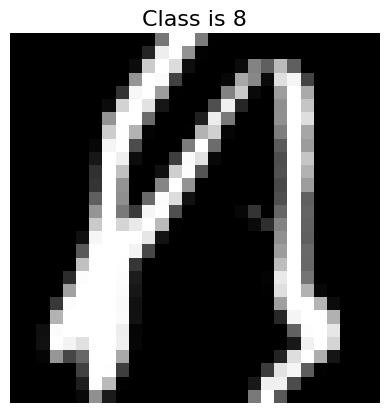

In [5]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





In [9]:
trainset[0][1]

8

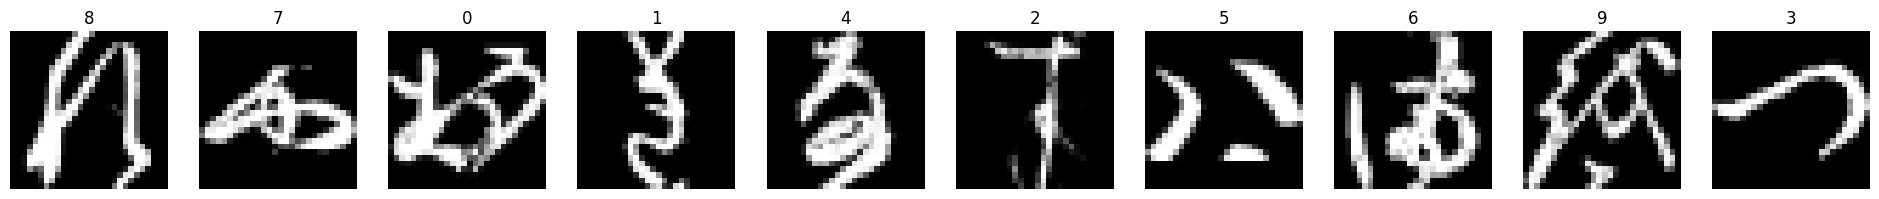

In [12]:
plt.rcParams["figure.figsize"] = 24, 13
tmp_list = []
i = 0
while len(tmp_list)<10:
  if not trainset[i][1] in tmp_list:
    tmp_list.append(trainset[i][1])

    plt.subplot(1, 10, len(tmp_list))
    pixels = trainset[i][0].reshape((28, 28))
    plt.imshow(pixels, cmap='gray')
    plt.title(tmp_list[-1])
    plt.axis("off")
  i+=1
# for i, (digit, image) in enumerate(zip(digits, images)):
#     plt.subplot(1, 10, i+1)
#     pixels = image.reshape((28, 28))
#     plt.imshow(pixels, cmap='gray')
#     plt.title(digit)
#     plt.axis("off")

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [19]:
import torch.nn as nn
import torch.nn.functional as F

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        logits = self.fc3(x)

        return logits

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

In [17]:
256*28*28+256 + 128*256+128 + 128*10+10

235146

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [20]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [21]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [22]:
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.9277
Epoch=2 loss=0.4582
Epoch=3 loss=0.3619
Epoch=4 loss=0.3004
Epoch=5 loss=0.2545
Epoch=6 loss=0.2222
Epoch=7 loss=0.1938
Epoch=8 loss=0.1701
Epoch=9 loss=0.1510
Epoch=10 loss=0.1323


In [23]:
get_accuracy(fc_net, testloader)

0.8754

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [42]:
mean = 0
std = 0
for images, labels in trainloader:
  mean += images.mean((0, 2, 3))
  std += images.std((0, 2, 3))

mean = mean/len(trainloader)
std = std/len(trainloader)

In [48]:
print(mean, std)

tensor([0.1918]) tensor([0.3483])


In [49]:
transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

In [50]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [51]:
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6872
Epoch=2 loss=0.2999
Epoch=3 loss=0.2197
Epoch=4 loss=0.1690
Epoch=5 loss=0.1357
Epoch=6 loss=0.1106
Epoch=7 loss=0.0915
Epoch=8 loss=0.0751
Epoch=9 loss=0.0614
Epoch=10 loss=0.0501


In [52]:
get_accuracy(fc_net, testloader)

0.8945

Как изменилась `accuracy` после нормализации?

После нормализации модель стала лучше обучаться)

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [53]:
import torch.nn as nn
import torch.nn.functional as F

class FCNet(nn.Module):
    def __init__(self, activation_f):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.activation_f = activation_f

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        x = x.view(-1, 28*28) # переведем картинку в вектор
        x = self.fc1(x)
        x = self.activation_f(x)
        x = self.fc2(x)
        x = self.activation_f(x)
        logits = self.fc3(x)

        return logits

**Sigmoid**

In [54]:
fc_net = FCNet(F.sigmoid)
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [55]:
%%time
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=1.5463
Epoch=2 loss=0.7488
Epoch=3 loss=0.5473
Epoch=4 loss=0.4484
Epoch=5 loss=0.3776
Epoch=6 loss=0.3230
Epoch=7 loss=0.2797
Epoch=8 loss=0.2442
Epoch=9 loss=0.2148
Epoch=10 loss=0.1893
CPU times: user 23.9 s, sys: 1.73 s, total: 25.7 s
Wall time: 2min 34s


In [56]:
get_accuracy(fc_net, testloader)

0.8556

**Tanh**

In [57]:
fc_net = FCNet(F.tanh)
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [58]:
%%time
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.7726
Epoch=2 loss=0.3774
Epoch=3 loss=0.2547
Epoch=4 loss=0.1828
Epoch=5 loss=0.1357
Epoch=6 loss=0.1031
Epoch=7 loss=0.0771
Epoch=8 loss=0.0573
Epoch=9 loss=0.0425
Epoch=10 loss=0.0313
CPU times: user 24.5 s, sys: 1.6 s, total: 26.1 s
Wall time: 2min 28s


In [59]:
get_accuracy(fc_net, testloader)

0.9022

**GELU**

In [60]:
fc_net = FCNet(F.gelu)
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [61]:
%%time
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6619
Epoch=2 loss=0.2845
Epoch=3 loss=0.2049
Epoch=4 loss=0.1585
Epoch=5 loss=0.1245
Epoch=6 loss=0.0995
Epoch=7 loss=0.0796
Epoch=8 loss=0.0644
Epoch=9 loss=0.0509
Epoch=10 loss=0.0415
CPU times: user 25 s, sys: 1.57 s, total: 26.6 s
Wall time: 2min 23s


In [62]:
get_accuracy(fc_net, testloader)

0.8998

С использованием какой функции активации удалось досчить наибольшей `accuracy`?

**Tanh** себя показал лучше всех

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

**RMSprop**

In [63]:
fc_net = FCNet(F.tanh)
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.RMSprop(fc_net.parameters(), lr=3e-4)

In [64]:
%%time
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.5634
Epoch=2 loss=0.3102
Epoch=3 loss=0.2139
Epoch=4 loss=0.1548
Epoch=5 loss=0.1153
Epoch=6 loss=0.0866
Epoch=7 loss=0.0642
Epoch=8 loss=0.0481
Epoch=9 loss=0.0359
Epoch=10 loss=0.0263
CPU times: user 22.6 s, sys: 1.75 s, total: 24.3 s
Wall time: 2min 15s


In [65]:
get_accuracy(fc_net, testloader)

0.8973

**Adagrad**

In [66]:
fc_net = FCNet(F.tanh)
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adagrad(fc_net.parameters(), lr=3e-4)

In [67]:
%%time
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=1.4159
Epoch=2 loss=1.0282
Epoch=3 loss=0.8946
Epoch=4 loss=0.8193
Epoch=5 loss=0.7699
Epoch=6 loss=0.7335
Epoch=7 loss=0.7057
Epoch=8 loss=0.6828
Epoch=9 loss=0.6644
Epoch=10 loss=0.6485
CPU times: user 22.4 s, sys: 1.68 s, total: 24 s
Wall time: 2min 16s


In [68]:
get_accuracy(fc_net, testloader)

0.6799

**Adam** не был побит по перформансу другими оптимизаторами

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [69]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x
        x = x.clip(0)
        return x

In [70]:
customrelu = CustomReLU()

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

**CustomRelu**

In [73]:
fc_net = FCNet(customrelu)
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [74]:
%%time
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6787
Epoch=2 loss=0.2991
Epoch=3 loss=0.2203
Epoch=4 loss=0.1718
Epoch=5 loss=0.1366
Epoch=6 loss=0.1134
Epoch=7 loss=0.0915
Epoch=8 loss=0.0755
Epoch=9 loss=0.0618
Epoch=10 loss=0.0505
CPU times: user 25.6 s, sys: 1.71 s, total: 27.3 s
Wall time: 2min 29s


In [75]:
get_accuracy(fc_net, testloader)

0.9001

**Relu** pytorch

In [76]:
fc_net = FCNet(F.relu)
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [77]:
%%time
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6904
Epoch=2 loss=0.3053
Epoch=3 loss=0.2227
Epoch=4 loss=0.1720
Epoch=5 loss=0.1366
Epoch=6 loss=0.1122
Epoch=7 loss=0.0921
Epoch=8 loss=0.0756
Epoch=9 loss=0.0614
Epoch=10 loss=0.0500
CPU times: user 23.4 s, sys: 1.63 s, total: 25.1 s
Wall time: 2min 29s


In [78]:
get_accuracy(fc_net, testloader)

0.8978

Хмммм, мой релу случайно оказался даже лучше

### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.